In [2]:
from abc import ABC, abstractmethod
import gymnasium as gym
import random
import numpy as np
import torch
import torch.nn as nn
from collections import OrderedDict
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy
import seaborn as sns
import pandas as pd

In [3]:
### MLP
class Multi_Layer_Perceptron(nn.Sequential):
    def __init__(self, input_dim, intern_dim, output_dim, depth = 2, isBiased = False):
        
        dict = OrderedDict([("input",nn.Linear(input_dim,intern_dim, bias=isBiased))])
        for i in range(depth):
            dict.update({str(i) : nn.Linear(intern_dim,intern_dim,bias=isBiased)})
        dict.update({"output" : nn.Linear(intern_dim,output_dim,bias=isBiased)})

        super().__init__(dict)

        self.reset_init_weights_biases(0) # so that we do not use a default initialization

    def reset_init_weights_biases(self, norm = -1):
        for layer in self.children():
            stdv = 1. / math.sqrt(layer.weight.size(1))
            if norm != -1 :
                stdv = norm
            layer.weight.data.uniform_(-stdv,stdv)
            if layer.bias is not None:
                layer.bias.data.uniform_(-stdv,stdv)

In [4]:
class Agent(ABC):

    @abstractmethod
    def observe(self, state, action, next_state, reward):
        pass

    @abstractmethod
    def select_action(self, state):
        pass
    
    @abstractmethod
    def update(self):
        pass

    def __init__(self, id, env):
        self.id = id
        self.env = env
                

In [5]:
class RandomAgent(Agent):
    def observe(self, state, action, next_state, reward):
        pass
        
    def select_action(self, state):
        return random.randint(0,1)
        
        
    def update(self):
        pass

    def train(self, episodes, debug_mode=False):
        episodesHistory = np.zeros((episodes))
        
        for i in range(episodes):
            if(debug_mode) : print("Episode: "+str(i+1)+" starts")
            newSeed = random.randint(0,100000)
            state,_ = self.env.reset(seed = newSeed)
            done = False
            episode_reward = 0
            
            while not done:
                                        
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                self.observe(state,action,next_state,reward)
                self.update()

                episode_reward += reward
                state = next_state
                done = terminated or truncated

            episodesHistory[i] = episode_reward
            if(debug_mode) : print("Episode "+str(i+1)+ " , Reward: "+str(episode_reward))
        print(episodesHistory[:])

In [22]:
class DQNAgent(Agent):

    def __init__(self, id, epsilonMax=1, epsilonMin = 0.05, reward_factor = 0.5, PredFirstUpdate = 200, PredList_batch = 200, env = gym.make('MountainCar-v0'), arrayNewPosReward = None, gamma = 0.99, replay_buffer_SIZE = 10000, batch_size = 64, observation_SIZE = 6):
        Agent.__init__(self,id,env)
        '''
        Definition of MLP for the Policy + the RND
        '''
        self.Q = Multi_Layer_Perceptron(input_dim = 2,intern_dim = 64, output_dim = 3, depth = 2, isBiased = False) # For the policy
        self.QTarget = Multi_Layer_Perceptron(input_dim = 2,intern_dim = 64, output_dim = 3, depth = 2, isBiased = False)
        self.Pred = Multi_Layer_Perceptron(input_dim = 2,intern_dim = 64, output_dim = 1, depth = 2, isBiased = False) # For the RND
        self.PredTarget = Multi_Layer_Perceptron(input_dim = 2,intern_dim = 64, output_dim = 1, depth = 2, isBiased = False)
        '''
        Definition of the hyperparameters for the training
        '''
        self.arrayNewPosReward = arrayNewPosReward # Heuristic Rewards
        self.reward_factor = reward_factor # For the RND
        self.gamma = gamma
        self.epsilon = epsilonMax
        self.epsilonMax = epsilonMax
        self.epsilonMin = epsilonMin
        '''
        Definition of the replay buffer
        '''
        self.replay_buffer_SIZE = replay_buffer_SIZE
        self.observation_SIZE = observation_SIZE
        self.replay_buffer = np.zeros((replay_buffer_SIZE,observation_SIZE))
        self.batch_size = batch_size
        '''
        Definition of the optimizer + loss function (there are 2 for the Q + RND)
        '''        
        self.optimizer = torch.optim.AdamW(self.Q.parameters())
        self.optimizer2 = torch.optim.AdamW(self.Pred.parameters())     
        self.LossFct = torch.nn.MSELoss()
        self.LossFct2 = torch.nn.MSELoss()
        '''
        Definition of parameters for the computing of the normalization (for the RND)
        '''        
        self.next_state_mean = 0
        self.next_state_std = 1
        self.RND_std = 1
        self.RND_mean = 0
        self.PredList = [] #History to compute the normalization
        self.PredList_batch = PredList_batch #When do we start to compute normalization
        self.PredFirstUpdate = PredFirstUpdate #When do we start to update the Q network (to be sure to have enough data for the normalization and avoid big value)
        '''
        Definition of extra informations
        '''   
        self.last_success_seed = 0 # To facilitate the test after training
        
    def observe(self, state, action, next_state, reward):
        state = np.array(state)
        action = np.array([action])
        next_state = np.array(next_state)
        reward = np.array([reward])

        concatenatation = np.concatenate((state, action, next_state, reward))
        return concatenatation
    '''
    Select actions with exploration (for the training)
    '''          
    def select_action(self, state):
        P = random.uniform(0,1)
        a=0
        if P <= 1-self.epsilon :
            arg = self.Q(torch.from_numpy(state).to(torch.float32)).max(axis = 0)[1].numpy()
            if arg.size == 1:
                a = arg
            else:
                a = np.random.choice(arg, size = 1)[0]
        else:
            a = random.randint(0,2)
        return a
    '''
    Select actions without exploration (for the tests)
    '''  
    def select_best_action(self, state):
        a = 0
        arg = self.Q(torch.from_numpy(state).to(torch.float32)).max(axis = 0)[1].numpy()
        if arg.size == 1:
            a = arg
        else:
            a = np.random.choice(arg, size = 1)[0]
        return a
    '''
    Update the Q network (j: nb of epochs)
    '''  
    def update(self,j):
        batchIndex = np.random.choice(min(j,self.replay_buffer.shape[0]), self.batch_size)
        batch = self.replay_buffer[batchIndex,:]
        target = torch.zeros((self.batch_size))
        input = torch.zeros((self.batch_size))

        A = torch.from_numpy(batch[:,3:5]).to(torch.float32)
        
        QMax = self.QTarget(A).max(axis = 1)[0].detach().numpy()
        target = torch.from_numpy(batch[:,5] + self.gamma*QMax).to(torch.float32)
        
        for i in range(A.shape[0]):
            if A[i,0] >= 0.5:
                target[i] = batch[i,5]
                 
        input = self.Q(torch.from_numpy(batch[:,:2]).to(torch.float32))[np.arange(batch.shape[0]),batch[:,2]]
        loss = self.LossFct(input, target)
        self.optimizer.zero_grad()
            
        loss.backward()

        grad = 0
        for layer in self.Q.children():
            grad += layer.weight.grad.mean()
        
        self.optimizer.step()
        return loss.item(), abs(grad)
    '''
    Update the predictor of RND (j: nb of epochs)
    '''          
    def update_Pred(self, j, next_state):

        L = 0
        if j <= self.PredList_batch:
            next_states = self.replay_buffer[:j,3:5]
            self.next_state_mean = np.mean(next_states, axis=0)
            next_state_mean_square = np.mean(next_states**2, axis=0)
            self.next_state_std = 2*(next_state_mean_square - self.next_state_mean**2)**(1/2)

        if j >= self.PredFirstUpdate:
            next_state = (next_state - self.next_state_mean)/self.next_state_std
            
            target = self.PredTarget(torch.from_numpy(next_state).to(torch.float32))
            input = self.Pred(torch.from_numpy(next_state).to(torch.float32))
            loss = self.LossFct2(input, target)
            RND = loss.detach().numpy().item()
    
            if RND > 5: RND = 5
            if RND < -5: RND = -5
    
            self.optimizer2.zero_grad()
            
            loss.backward()
            self.optimizer2.step()
            
            if len(self.PredList) <= self.PredList_batch:
                self.PredList.append(RND)
                self.RND_mean = sum(self.PredList) / float(len(self.PredList))
                RND_mean_square = sum([ x**2 for x in self.PredList ]) / float(len(self.PredList))
                self.RND_std = math.sqrt(RND_mean_square - self.RND_mean**2)
                
            if len(self.PredList) >= self.PredList_batch:
                    
                RND = (RND - self.RND_mean)/self.RND_std
                
                if RND > 5: RND = 5
                if RND < -5: RND = -5
                    
            else: RND = 0
                
            L = loss.item()
        else: RND = 0
            
        return RND, L
    '''
    customReward: Heuristic or/and RND (uniqueReward: heuristic reward can be taken only one time during an episode)
    '''        
    def customReward(self, state, action, currentReward, next_state, uniqueReward, RND):
        reward = -1
     
        if self.arrayNewPosReward.all() != None:
            for k in range(self.arrayNewPosReward.shape[0]):
                #print(i)
                i = self.arrayNewPosReward[k,0]
                if (i <= next_state[0] and i +0.5 >=0) or (i >= next_state[0] and i +0.5 <=0):
                    if self.arrayNewPosReward[k,2] == 0:
                        if self.arrayNewPosReward[k,1] > reward:
                            reward = self.arrayNewPosReward[k,1]
                            if uniqueReward: self.arrayNewPosReward[k,2] = 1
                                
        return reward + self.reward_factor*RND
    '''
    Test the agent on a seed (random or not) after the training
    '''  
    def play(self, seed = False):
        newSeed = random.randint(0,100000)
        
        if seed != False:
            newSeed = seed
            
        state,_ = self.env.reset(seed = newSeed)
        done = False
                    
        while done == False:
                                        
            action = self.select_best_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            state = next_state
            done = terminated or truncated
        self.env.close()
    '''
    All the training process   (lossLim: to do an early stopping (avoid training collaps) ; 
                                limitStep: to increase length of an episode ; 
                                refreshQ: to update Q (should be each epochs/actions) ; 
                                buffer_fill: to continue to fill the replay_buffer if it's full ;
                                epsilonDecreasing: how fast epsilon decrease during the training (exponentially) ;
                                debug_mode: print each action information ;
                                recap_mode: print each episode information ;
                                reset_init: to reset the weight at the start of the training (norm can be choosen by passing a float) ;
    '''  
    def train(self, episodes,lossLim = 0, refreshQTarget = 10000, buffer_fill = True, epsilonDecreasing =100, debug_mode=False, recap_mode=False, reset_init = False, epsilon_decrease = True, uniqueReward = False):

        episodesHistory = np.zeros((episodes))
        rewardHistory = np.zeros((episodes*200))
        lossHistory = np.zeros((int(episodes*200)))
        lossRNDHistory = np.zeros((int(episodes*200)))
        gradHistory = np.zeros((int(episodes*200)))
        cumulativeHistory = np.zeros((episodes))
        
        if reset_init != False:
            self.Q.reset_init_weights_biases(reset_init)
            self.Pred.reset_init_weights_biases(reset_init)
            self.PredTarget.reset_init_weights_biases(reset_init)
        self.QTarget.load_state_dict(self.Q.state_dict())
        self.replay_buffer = np.zeros((self.replay_buffer_SIZE, self.observation_SIZE))
        k=0
        j=0
        for e in tqdm(range(episodes)):
            l=0
            terminated = False
            if debug_mode: print("Episode: "+str(e+1)+" starts")
                
            if epsilon_decrease: 
                if self.epsilon > self.epsilonMin:
                    self.epsilon = self.epsilonMax*math.exp(-e/epsilonDecreasing)
            else:
                self.epsilon = self.epsilonMax
                
            newSeed = random.randint(0,100000)
            state,_ = self.env.reset(seed = newSeed)
            done = False
            episode_reward = 0
            if self.arrayNewPosReward.all() != None:
                for i in range(self.arrayNewPosReward.shape[0]):
                    self.arrayNewPosReward[i,2] = 0

            s=1
            while done == False:
                j+=1
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                
                RND = 0
                loss_RND = 0
                if self.reward_factor != 0: RND, loss_RND = self.update_Pred(j,next_state)
                lossRNDHistory[j-1] = loss_RND

                s+=1
                reward = self.customReward(state, action,reward, next_state, uniqueReward,RND)
                if debug_mode: print("Action "+str(k)+" selected: "+str(action)+" Reward: "+ str(reward))
                    
                observe = self.observe(state,action,next_state,reward)
                
                if k < self.replay_buffer_SIZE: self.replay_buffer[k] = observe
                elif buffer_fill: k=-1
                k+=1
                
                episode_reward += reward
                state = next_state
                done = terminated or truncated
                if j%refreshQ == 0 and j >= self.PredFirstUpdate:
                    #start_time = time.time()
                    l,g = self.update(j)
                    #print(time.time() - start_time)
                    lossHistory[int(j/refreshQ)-1] = l
                    gradHistory[int(j/refreshQ)-1] = g
                if j%refreshQTarget == 0:
                    if recap_mode: print("Loss: "+str(l))
                    self.QTarget.load_state_dict(self.Q.state_dict())
                    #for param in self.Q.parameters():
                        #print(param.data)
                rewardHistory[j-1] = reward
                
                if terminated:
                    self.last_success_seed = newSeed
                    if e > 0:
                        cumulativeHistory[e] = cumulativeHistory[e-1] +1
                    else:
                        cumulativeHistory[e] = 1
                else:
                    if e > 0:
                        cumulativeHistory[e] = cumulativeHistory[e-1]
                    else:
                        cumulativeHistory[e] = 0
                                    
            if debug_mode or recap_mode: print("Episode "+str(e+1)+ " , Reward: "+str(episode_reward)+" Epsilon: "+str(self.epsilon))
            episodesHistory[e] = episode_reward
            
            if l <= lossLim:
                print("Loss reaches limit")
                break
        return episodesHistory, rewardHistory, lossHistory, gradHistory, cumulativeHistory, lossRNDHistory, self.Q.state_dict()

In [23]:
def plot_all_results(episodesHistory, rewardHistory, lossHistory, gradHistory, cumulativeHistory, lossRNDHistory, episodes, u, batch_size, reward_factor, refreshQTarget, reset_init, replay_buffer_SIZE, epsilonDecreasing):

    fig1,ax1 = plt.subplots(1,1)
    ax1.plot(range(episodesHistory.shape[0]), episodesHistory, marker='.')
    ax1.set_title(f'TotalReward QTargetRefresh: {refreshQTarget}')
    if u>0: ax1.set_title(f'TotalReward with heuristic reward QTargetRefresh: {refreshQTarget}')
    if reward_factor>0:ax1.set_title(f'TotalReward with RND RewardFactor: {reward_factor} QTargetRefresh: {refreshQTarget}')
    ax1.set_xlabel(r'episodes $t$')
    ax1.set_ylabel(r'$Total Reward$')
    ax1.set_xscale('linear')
    ax1.set_yscale('linear')
    plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
    plt.savefig(f'figures/TotalReward_ep{episodes}_u{u}_bS{batch_size}_rF{reward_factor}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')
    
    fig2,ax2 = plt.subplots(1,1)
    ax2.plot(range(rewardHistory.shape[0]), rewardHistory, marker='.')
    ax2.set_title(f'Reward QTargetRefresh: {refreshQTarget}')
    if u>0: ax2.set_title(f'Reward with heuristic reward QTargetRefresh: {refreshQTarget}')
    if reward_factor>0:ax2.set_title(f'Reward with RND RewardFactor: {reward_factor} QTargetRefresh: {refreshQTarget}')
    ax2.set_xlabel(r'Step $t$')
    ax2.set_ylabel(r'$Reward$')
    ax2.set_xscale('linear')
    ax2.set_yscale('linear')
    plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
    plt.savefig(f'figures/Reward_ep{episodes}_u{u}_bS{batch_size}_rF{reward_factor}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')
    
    
    fig3,ax3 = plt.subplots(1,1)
    ax3.plot(range(lossHistory.shape[0]), lossHistory, marker='.')
    ax3.set_title(f'Loss QTargetRefresh: {refreshQTarget}')
    if u>0: ax3.set_title(f'Loss with heuristic reward QTargetRefresh: {refreshQTarget}')
    if reward_factor>0:ax3.set_title(f'Loss with RND RewardFactor: {reward_factor} QTargetRefresh: {refreshQTarget}')
    ax3.set_xlabel(r'Update $t$')
    ax3.set_ylabel(r'$Loss$')
    ax3.set_xscale('linear')
    ax3.set_yscale('log')
    #plt.ylim(top=0.15)
    plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
    plt.savefig(f'figures/Loss_ep{episodes}_u{u}_bS{batch_size}_rF{reward_factor}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')
    
    fig3b,ax3b = plt.subplots(1,1)
    ax3b.plot(range(lossRNDHistory.shape[0]), lossRNDHistory, marker='.')
    ax3b.set_title(f'RNDLoss QTargetRefresh: {refreshQTarget}')
    if u>0: ax3b.set_title(f'RNDLoss with heuristic reward QTargetRefresh: {refreshQTarget}')
    if reward_factor>0:ax3b.set_title(f'RNDLoss with RND RewardFactor: {reward_factor} QTargetRefresh: {refreshQTarget}')
    ax3b.set_xlabel(r'Update $t$')
    ax3b.set_ylabel(r'$RNDLoss$')
    ax3b.set_xscale('linear')
    ax3b.set_yscale('log')
    plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
    plt.savefig(f'figures/LossRND_ep{episodes}_u{u}_bS{batch_size}_rF{reward_factor}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')
    
    fig4,ax4 = plt.subplots(1,1)
    ax4.plot(range(gradHistory.shape[0]), gradHistory, marker='.')
    ax4.set_title(f'Gradient QTargetRefresh: {refreshQTarget}')
    if u>0: ax4.set_title(f'Gradient with heuristic reward QTargetRefresh: {refreshQTarget}')
    if reward_factor>0:ax4.set_title(f'Gradient with RND RewardFactor: {reward_factor} QTargetRefresh: {refreshQTarget}')
    ax4.set_xlabel(r'Update $t$')
    ax4.set_ylabel(r'$Gradient$')
    ax4.set_xscale('linear')
    ax4.set_yscale('log')
    plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
    plt.savefig(f'figures/Grad_ep{episodes}_u{u}_bS{batch_size}_rF{reward_factor}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')
    
    
    s=0
    for e in range(cumulativeHistory.shape[0]):
        if cumulativeHistory[e] == 1:
            s = e
            break
    fig5,ax5 = plt.subplots(1,1)
    ax5.plot(range(cumulativeHistory.shape[0]), cumulativeHistory[:], marker='.')
    ax5.set_title(f'CumulativeSucess QTargetRefresh: {refreshQTarget}')
    if u>0: ax5.set_title(f'CumulativeSucess with heuristic reward QTargetRefresh: {refreshQTarget}')
    if reward_factor>0:ax5.set_title(f'CumulativeSucess with RND RewardFactor: {reward_factor} QTargetRefresh: {refreshQTarget}')
    ax5.set_xlabel(r'episodes: first_success: ep '+str(s))
    ax5.set_ylabel(r'$CumulativeSucess$')
    ax5.set_xscale('linear')
    ax5.set_yscale('linear')
    plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
    plt.savefig(f'figures/CumulativeSucess_ep{episodes}_u{u}_bS{batch_size}_rF{reward_factor}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

In [25]:
u=0.05
episodes = 300
lossLimTrain = -1
batch_size = 64
refreshQ = 1
refreshQTarget = 50000
reset_init = 1
replay_buffer_SIZE = 10000
epsilonDecreasing = 100
reward_factor = 0
PredList_batch = 0
PredFirstUpdate = 0

NewPosReward=np.array([(-1.1,u*7,0),(-1,u*6,0),(-0.9,u*5,0),(-0.8,u*4,0),(-0.7,u*3,0),(-0.6,u*2,0),(-0.4,u*2,0),(-0.3,u*3,0),(-0.2,u*4,0),(-0.1,u*5,0),(0,u*6,0),(0.1,u*7,0),(0.2,u*8,0),(0.3,u*9,0),(0.4,u*10,0),(0.5,20*u,0)])
No = np.array([None])

DQN = DQNAgent("id0",epsilonMax = 1, PredFirstUpdate = PredFirstUpdate, PredList_batch = PredList_batch, reward_factor = reward_factor, epsilonMin = 0.05, batch_size = batch_size, arrayNewPosReward = NewPosReward, replay_buffer_SIZE = replay_buffer_SIZE)
episodesHistory, rewardHistory, lossHistory, gradHistory, cumulativeHistory, lossRNDHistory, Q_Trained = DQN.train(episodes,lossLim=lossLimTrain,buffer_fill = True, refreshQTarget = refreshQTarget, debug_mode = False, recap_mode=False, reset_init = reset_init, uniqueReward = False, epsilonDecreasing =epsilonDecreasing)


100%|██████████| 300/300 [03:08<00:00,  1.59it/s]


C:\Users\triox\AppData\Local\Temp\ipykernel_12400\2485583216.py:49: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax3b.set_yscale('log')


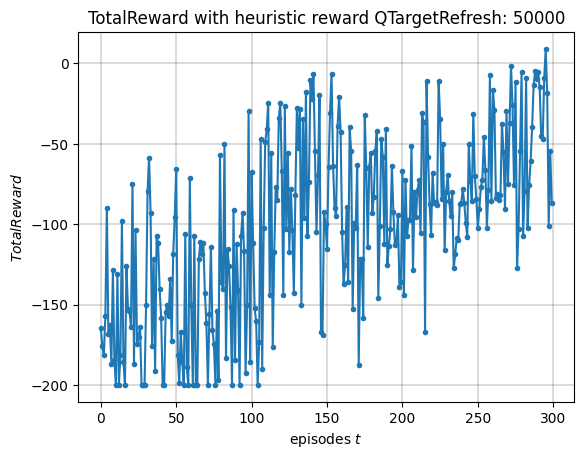

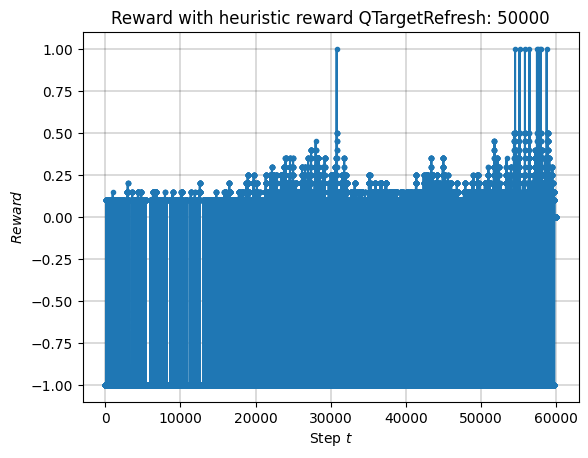

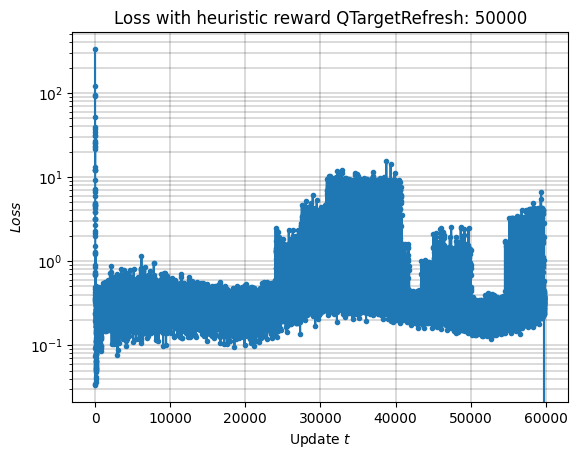

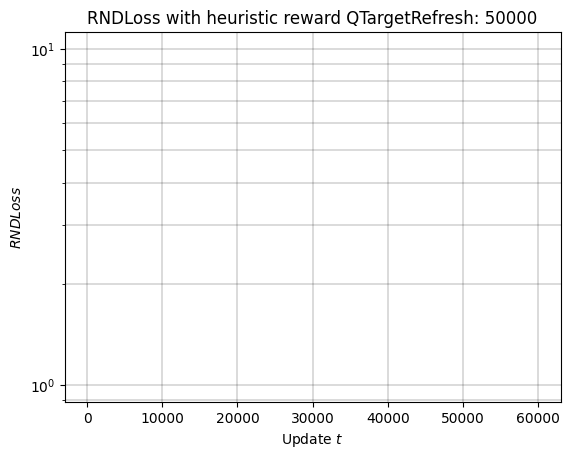

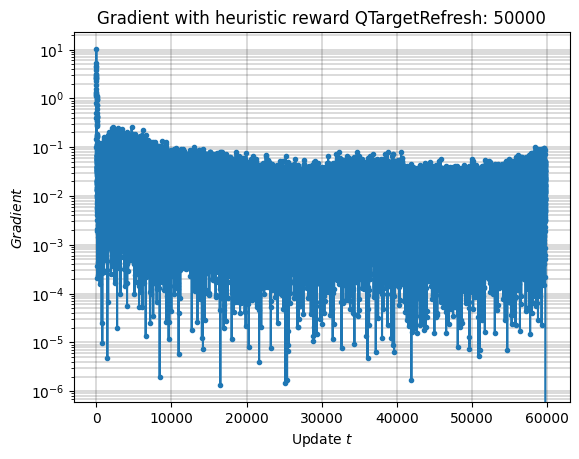

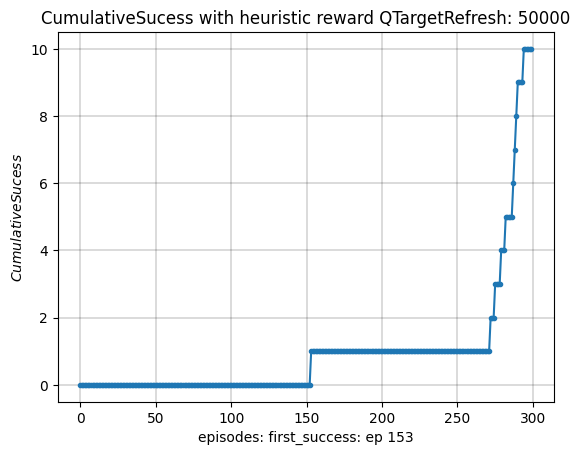

In [26]:
plot_all_results(episodesHistory, rewardHistory, lossHistory, gradHistory, cumulativeHistory, lossRNDHistory, episodes, u, batch_size, reward_factor, refreshQTarget, reset_init, replay_buffer_SIZE, epsilonDecreasing)

In [ ]:
Q = Multi_Layer_Perceptron(input_dim = 2,intern_dim = 64, output_dim = 3, depth = 2, isBiased = False)
Q.load_state_dict(Q_Trained)
DQN_Test = DQNAgent("idTest", env=gym.make('MountainCar-v0', render_mode='human'))
DQN_Test.Q = Q
DQN_Test.play(seed = False)